In [0]:
!pip install -U sklearn
!pip install -U numpy
!pip install -U matplotlib

In [0]:
import numpy as np
import time
from sklearn.datasets.samples_generator import make_blobs

# Visualization
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# Plotly
import plotly
plotly.tools.set_credentials_file(username='DacNguyen', api_key='KRNQwMHIUfVok8sf147j')
import plotly.plotly as py
import plotly.graph_objs as go

# Necessary functions

In [0]:
# classify X
def f(X, w):
    y_pre = (np.matmul(X, w.T))
    return y_pre
    
def calculate_loss(y, y_pre):
    loss_list = np.array(1 - y*y_pre)  # 1 - y[i]*y_pre[i]
    
    # Check if y is a scalar
    if loss_list.size == 1:
        if loss_list < 0:
            return np.array([0])
        else:
            return np.array([loss_list])
        
    loss_list[loss_list < 0] = 0  # max(0, 1 - y[i]*y_pre[i])
    return loss_list

### GRADIENT DESCENT

In [0]:
def gradient_descent(w, X, y, min_diff = 10e-5,
                     lr = 10e-6, lamb = 1, 
                     epochs = 200, warn = 1):
    '''
    INPUT
        w: weights (vector)
        X: samples (matrix)
        y: labels (vector)
        min_diff: minimum difference between current loss and previous loss to continue
        lr: learning rate
        warn: 0 to disable all warning, 1 to enable all, 2 to disable epoch
    OUTPUT
        loss_list
        weights
        y_pre
        consuming_time_list
    '''
    if warn != 0:
        print('Processing Gradient Descent')
    
    # Init loss and weight
    y_pre = f(X, w)
    loss_elements = calculate_loss(y, y_pre)
    current_loss = np.sum(loss_elements)  # Cost (loss)
    weights = {current_loss: w}
    consuming_time_list = []
    
    iters = 0    
    while iters < epochs:        
        start_time = time.time() # Start time log
        
        
        available_loss_vector = np.ones(loss_elements.shape[0])
        available_loss_vector[loss_elements == 0] = 0  # On - Off vector
        
        # Hinge loss and weights
        if loss_elements.shape[0] != 1: # When X is a matrix
            hinge_loss = np.matmul((-y.T*available_loss_vector), X)/loss_elements.shape[0]  # 1/N * sum(max(0, 1 - y*w*x_T))
        else: 
            # When X is a vector
            hinge_loss = -y.T*available_loss_vector*X  # max(0, 1 - y*w*x_T)
            
        gra_w = lamb*weights[current_loss] + hinge_loss  # J/dw = lambda * w + hinge loss
        current_weight = weights[current_loss] - lr*gra_w # w_new = w - lr * J/dw
        
        
        end_time = time.time() # End time log
        y_pre = f(X, current_weight)
        loss_elements = calculate_loss(y, y_pre) 
        new_loss = np.sum(loss_elements)  # LOSS
        weights[new_loss] = current_weight
                           
        # Stop when the change is too small
        if abs(new_loss - current_loss) < min_diff or new_loss == 0:
            break
        else:
            current_loss = new_loss
        consuming_time_list.append(end_time - start_time)
        if warn == 1: # print current state of processing
            print('\tEpoch {}: loss: {}, time: {}'.format(iters, 
                                                          round(new_loss, 7), 
                                                          round(end_time - start_time, 5)))
        iters += 1    
    loss_list = list(weights.keys()) # Get loss_list as list
    y_pre = f(X, weights[min(loss_list)])
    
    if warn != 0:
        print('Done')
    return (loss_list, weights, y_pre, consuming_time_list)

### STOCHASTIC GRADIENT DESCENT & MINI-BATCH GRADIENT DESCENT

In [0]:
import random


def enhanced_gradient_descent(w, X, y, lr=10e-6, size=1000, lamb=1, epochs=2, gd_type='stochastic'):
    '''
    INPUT
        w: weights (vector)
        X: sample (matrix)
        y: label (vector)
        lr: learning rate
        size: size of each batch
        gd_type: stochastic (default) or mini_batch 
    OUTPUT
        loss_list: list loss after each epoch
        weights: vector weights corresponding to loss_list
    '''
    
#     print('Processing Stochastic Gradient Descent')
       
    # Choose elements randomly
    def choose_position(y):
        y_unit = np.unique(y)
        len_y_unit = len(y_unit)
        positions = []
        for i in y_unit:
            positions += random.choices(
                np.argwhere(y == 1).T[0].tolist(),
                k=size//len_y_unit
            )
        return positions
    
    # Initiation
    consuming_time_list = []
    y_pre = f(X, w)
    current_loss = np.sum(calculate_loss(y, y_pre))
    weights ={current_loss: w} # init weight
    loss_list = []
    loss_list.append(current_loss)
    
    iters = 0
    if gd_type == 'stochastic':
        while iters < epochs:            
            positions = choose_position(y)  # Get random samples
            current_weight = np.copy(w)
            start_time = time.time()
            
      
            # GD on a random sample
            for position in positions:
                loss_list_gd, weights_gd, y_pre_gd, t = gradient_descent(  
                    weights[current_loss], X[position], y[position], 
                    lr=lr, epochs=1, lamb=lamb, warn=0)
                current_weight += weights_gd[min(loss_list_gd)] # Accumulate      
                
                
            # Append to loss_list and weights
            current_weight /= size  # new weight = 1/N sum(weight of each point)
            end_time = time.time() # End time log
            current_loss = np.sum(calculate_loss(y, f(X, current_weight)))
            loss_list.append(current_loss)
            weights[current_loss] = current_weight
            
            
            consuming_time_list.append(end_time - start_time)
#             print('\tEpoch {}: loss: {}, time: {}'.format(iters, 
#                                                           round(current_loss, 7), 
#                                                           round(end_time - start_time, 5)))
            iters += 1
    elif gd_type == 'mini_batch':
        current_weight = np.copy(w)
        
        while iters < epochs:
            start_time = time.time() # Start time log
            positions = choose_position(y)

            
            # GD on a small batch only
            loss_list_gd, weights_gd, y_pre_gd, t = gradient_descent(  
                current_weight, X[positions], y[positions], 
                lr=lr, epochs=1, lamb=lamb, warn=0)
            
            
            # Append to loss_list and weights
            current_weight = weights_gd[min(loss_list_gd)]  # w_new = w of epoch
            end_time = time.time() # End time log
            current_loss = np.sum(calculate_loss(y, f(X, current_weight)))
            loss_list.append(current_loss)
            weights[current_loss] = current_weight
            
            
            consuming_time_list.append(end_time - start_time)
#             print('\tEpoch {}: loss: {}, time: {}'.format(iters, 
#                                                           round(current_loss, 7),
#                                                           round(end_time - start_time, 5)))
            iters += 1
            
        
#     print('Done')
    return loss_list, weights, consuming_time_list

#2 classes


### Compute for visualization

In [0]:
def compute_x1(w, x2):
    return (-w[1] * x2 - w[2])/w[0]

def compute_y(w, x1, x2):
    return w[0]*x1 + w[1]*x2 + w[2]

### Visualization

In [0]:
from matplotlib import animation, rc
from IPython.display import HTML


def visualize_loss_and_scatterplot(fig, ax, X, y, w_gd, w_sgd, w_mbgd, w_lg):
    '''Resize loss_list of GD and SGD'''
    def resize_loss_list(W):
        # measure skip value
        skip_range = int(len(W.keys())/70) # skip first and last
        loss_list = []

        if skip_range == 0:
            loss_list = list(W.keys())
            while len(loss_list) < 102:
                loss_list.append(min(loss_list))
            return loss_list

        for i in range(len(W.keys())):
            if i%skip_range == 0:
                loss_list.append(list(W.keys())[i])

        # add min loss to loss_list
        if min(loss_list) != min(W.keys()):
            loss_list.append(min(W.keys()))
        return loss_list
    
    loss_list_gd = resize_loss_list(w_gd)
    loss_list_sgd = resize_loss_list(w_sgd)
    loss_list_mbgd = resize_loss_list(w_mbgd)
        
    '''AX 0 LOSS VISUALIZATION'''
    ax[0].plot(loss_list_gd, label='Gradient Descent')
    ax[0].plot(loss_list_sgd, label='Stochastic Gradient Descent')
    ax[0].plot(loss_list_mbgd, label='Mini-batch Gradient Descent')

    ax[0].legend(loc='best')

    # Moving vline initiation
    vline = ax[0].axvline(x=0, color='r', linestyle='--')
    def init_loss_vline():
        ax[0].set_xlabel('$No. Epoch$')
        ax[0].set_ylabel('$Loss$')
        vline.set_xdata(0)
        return vline

    def animate_loss_vline(i):
        vline.set_xdata(i)
        return vline


    '''AX 1 MOVING SPLITTING LINE'''
    ## Initiation ##
    ax[1].scatter(X[y == -1, 0], X[y == -1, 1], label="Cluster 1", s=40, alpha=0.5)
    ax[1].scatter(X[y == 1, 0], X[y == 1, 1], label="Cluster 2", s=40, alpha=0.5)
    ax[1].set_xlabel('$x_1$')
    ax[1].set_ylabel('$x_2$')

    x2_min, x2_max = ax[1].get_ybound()
    ax[1].set_ylim((x2_min, x2_max))
    ax[1].set_xlim((min(X[:, 0]), max(X[:, 0])))

    # Animating line
    line, = ax[1].plot([0, 0], [0, 0], color='black', lw=5.0, alpha=0.5)
    # Functions
    def init_line():
        # GD best line
        x1_min = compute_x1(w_gd[min(loss_list_gd)], x2_min)
        x1_max = compute_x1(w_gd[min(loss_list_gd)], x2_max)
        gd_line = ax[1].plot([x1_min, x1_max], [x2_min, x2_max], lw=5.0, alpha=0.7, label='GD')

        # SGD line
        x1_min = compute_x1(w_sgd[min(loss_list_sgd)], x2_min)
        x1_max = compute_x1(w_sgd[min(loss_list_sgd)], x2_max)
        sgd_line = ax[1].plot([x1_min, x1_max], [x2_min, x2_max], lw=5.0, alpha=0.7, label='SGD')
        
        # SGD line
        x1_min = compute_x1(w_mbgd[min(loss_list_mbgd)], x2_min)
        x1_max = compute_x1(w_mbgd[min(loss_list_mbgd)], x2_max)
        mbgd_line = ax[1].plot([x1_min, x1_max], [x2_min, x2_max], lw=5.0, alpha=0.7, label='MBGD')

        # Lagrange line
        x1_min = compute_x1(w_lg, x2_min)
        x1_max = compute_x1(w_lg, x2_max)
        lag_line = ax[1].plot([x1_min, x1_max], [x2_min, x2_max], lw=5.0, alpha=0.7, label='Lagrange')
        
        ax[1].legend(loc='best')
        return line,

    def animate_line(i):
        x1_min = compute_x1(w_gd[loss_list_gd[i]], x2_min)
        x1_max = compute_x1(w_gd[loss_list_gd[i]], x2_max)
        line.set_data([x1_min, x1_max], [x2_min, x2_max])
        return line,

    def init():
        vline = init_loss_vline()
        line, = init_line()
        return vline, line, 

    def animate(i):
        vline = animate_loss_vline(i)
        line, = animate_line(i)
        return vline, line,
    
    frames = len(loss_list_gd)-1
    interval=len(loss_list_gd)-1
    
    ani = animation.FuncAnimation(fig, animate, init_func=init, frames=len(loss_list_gd)-1, interval=len(loss_list_gd)-1)
    return ani

## Completely Separated

In [0]:
centers = [(-20, 100), (300, 600)]
cluster_std = [50, 100]

X, y = make_blobs(n_samples=8000, cluster_std=cluster_std, centers=centers, n_features=2, random_state=1)
X -= np.mean(X, axis=0)  # Normalize
X = np.append(X, np.ones((X.shape[0], 1)), axis = 1) # add bias at last
y[y == 0] = -1
w = np.random.rand(X.shape[1]) # add bias at last (column vector)

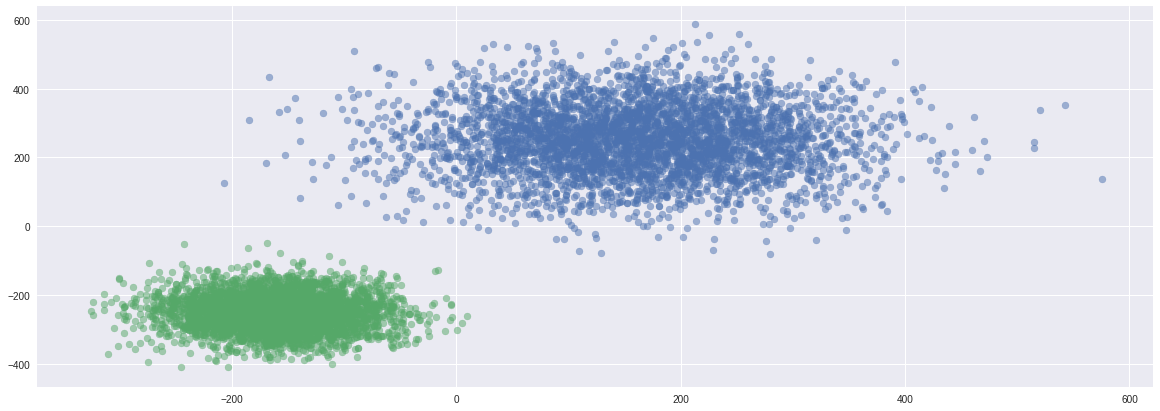

In [8]:
fig, ax = plt.subplots(figsize=(20, 7))
ax.scatter(x=X[y == 1, 0], y=X[y == 1, 1], label='Cluster 1', alpha=0.5)
ax.scatter(x=X[y == -1, 0], y=X[y == -1, 1], label='Cluster 1', alpha=0.5)

### Processing

In [141]:
loss_list_gd_ld = []
for lamb in range(1, 21):
    loss_list_gd, weights_gd, y_pre, time_list_gd = gradient_descent(w, X, y, lr=10e-3, lamb=lamb, epochs=200, warn=0)
    loss_list_gd_ld.append(round(min(loss_list_gd), 7))
    print('Min loss {} for {}s'.format(round(min(loss_list_gd), 7), round(sum(time_list_gd), 5)))

lamb = loss_list_gd_ld.index(min(loss_list_gd_ld)) + 1
print('Best lambda is: {}'.format(lamb))
loss_list_gd, weights_gd, y_pre, time_list_gd = gradient_descent(w, X, y, lr=10e-3, lamb=lamb, epochs=200, warn=0)


Min loss 10.883892 for 0.02823s
Min loss 11.0435405 for 0.02151s
Min loss 11.9303611 for 0.02139s
Min loss 12.5201463 for 0.02152s
Min loss 13.2114211 for 0.0098s
Min loss 13.8875995 for 0.0082s
Min loss 14.2413806 for 0.02675s
Min loss 14.4788444 for 0.02163s
Min loss 15.0095001 for 0.02243s
Min loss 15.3070534 for 0.02431s
Min loss 15.6559651 for 0.022s
Min loss 15.9387434 for 0.02291s
Min loss 16.1139886 for 0.02208s
Min loss 16.3347011 for 0.02187s
Min loss 16.5081589 for 0.02221s
Min loss 16.3756628 for 0.02212s
Min loss 16.4536368 for 0.02493s
Min loss 16.9292417 for 0.02274s
Min loss 17.0646237 for 0.02272s
Min loss 17.192777 for 0.03102s
Best lambda is: 1


Stochastic Gradient Descent

In [142]:
loss_list_sgd_ld = []
for lamb in range(1, 21):
    loss_list_sgd, weights_sgd, time_list_sgd = enhanced_gradient_descent(w, X, y, lr=10e-3, lamb=lamb, size=100, epochs = 200)
    loss_list_sgd_ld.append(round(min(loss_list_sgd), 7))
    print('Min loss {} for {}s'.format(round(min(loss_list_sgd), 7), round(sum(time_list_sgd), 5)))
    
lamb = loss_list_sgd_ld.index(min(loss_list_sgd_ld)) + 1
print('Best lambda is: {}'.format(lamb))
loss_list_sgd, weights_sgd, time_list_sgd = enhanced_gradient_descent(w, X, y, lr=10e-3, lamb=lamb, size=100, epochs = 200)

Min loss 132.0405547 for 2.03792s
Min loss 43.6508256 for 2.00675s
Min loss 26.506711 for 2.01362s
Min loss 12.8774806 for 2.00981s
Min loss 11.1537473 for 2.02381s
Min loss 11.0071665 for 2.0139s
Min loss 10.91774 for 1.98888s
Min loss 11.0430004 for 1.9793s
Min loss 11.1117755 for 2.00264s
Min loss 11.3513748 for 1.98512s
Min loss 11.3066743 for 2.01432s
Min loss 11.5736229 for 1.99222s
Min loss 11.0347276 for 2.01466s
Min loss 12.0132546 for 1.97699s
Min loss 11.6394867 for 2.00482s
Min loss 12.0234773 for 2.00712s
Min loss 11.8950454 for 2.03091s
Min loss 12.0514715 for 2.0498s
Min loss 11.6161982 for 2.00861s
Min loss 11.8594768 for 1.99531s
Best lambda is: 7


Mini-batch Gradient Descent

In [143]:
loss_list_mbgd_ld = []
for lamb in range(1, 21): 
    loss_list_mbgd, weights_mbgd, time_list_mbgd = enhanced_gradient_descent(w, X, y, lr=10e-3, lamb=lamb, size=100, epochs = 200, gd_type='mini_batch')
    loss_list_mbgd_ld.append(round(min(loss_list_mbgd), 7))
    print('Min loss {} for {}s'.format(round(min(loss_list_mbgd), 7), round(sum(time_list_mbgd), 5)))
    
lamb = loss_list_mbgd_ld.index(min(loss_list_mbgd_ld)) + 1
print('Best lambda is: {}'.format(lamb))
loss_list_mbgd, weights_mbgd, time_list_mbgd = enhanced_gradient_descent(w, X, y, lr=10e-3, lamb=lamb, size=100, epochs = 200, gd_type='mini_batch')

Min loss 10.9857518 for 0.19303s
Min loss 11.0350105 for 0.19571s
Min loss 10.9651176 for 0.19148s
Min loss 11.0357364 for 0.19483s
Min loss 13.1529119 for 0.1902s
Min loss 11.9486233 for 0.19378s
Min loss 11.5037921 for 0.19325s
Min loss 12.1279876 for 0.20119s
Min loss 12.2098273 for 0.19529s
Min loss 11.7245117 for 0.19396s
Min loss 12.2636748 for 0.19364s
Min loss 12.0225972 for 0.19376s
Min loss 12.5637514 for 0.19302s
Min loss 11.2531382 for 0.20018s
Min loss 11.5554435 for 0.1991s
Min loss 11.1747362 for 0.19313s
Min loss 11.6895809 for 0.19395s
Min loss 12.0470899 for 0.19639s
Min loss 12.3678772 for 0.20218s
Min loss 12.5343212 for 0.19936s
Best lambda is: 3


### Visualizing

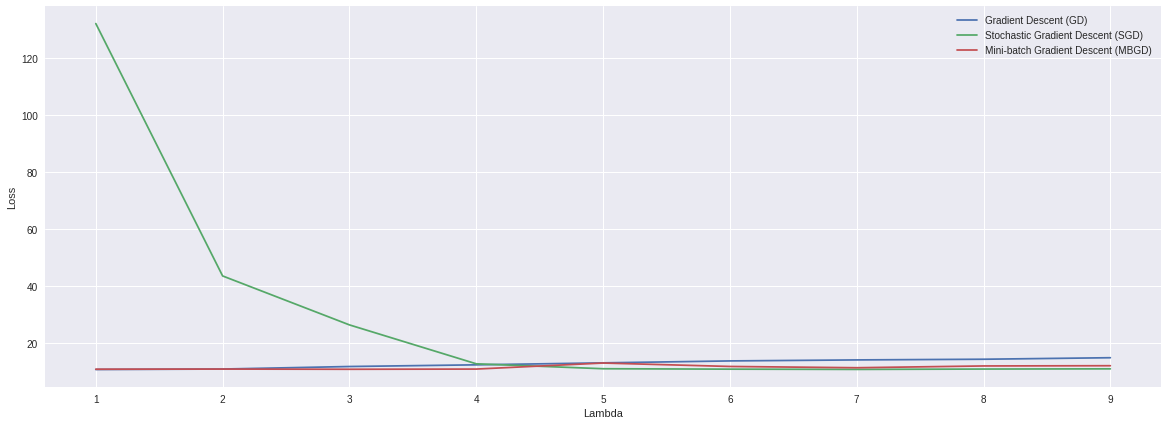

In [144]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,7))

for loss_list, label in zip([loss_list_gd_ld, loss_list_sgd_ld, loss_list_mbgd_ld],
                                   ['Gradient Descent (GD)', 
                                    'Stochastic Gradient Descent (SGD)', 
                                    'Mini-batch Gradient Descent (MBGD)']
                                  ):
    ax.plot(range(1, 10), loss_list[0:9], label=label, alpha=1)
ax.set_ylabel('Loss')
ax.set_xlabel('Lambda')

ax.legend(loc='best')

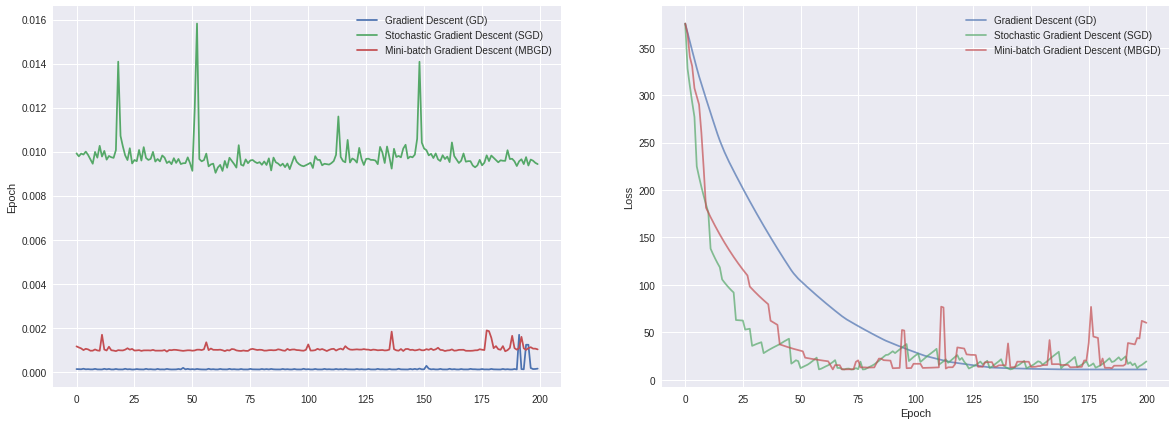

In [145]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,7))

for time_list, label in zip([time_list_gd, time_list_sgd, time_list_mbgd],
                            ['Gradient Descent (GD)', 
                             'Stochastic Gradient Descent (SGD)', 
                             'Mini-batch Gradient Descent (MBGD)']):
    ax[0].plot((range(len(time_list_gd))), time_list, label=label, alpha=1)
ax[0].set_ylabel('Time Consuming')
ax[0].set_ylabel('Epoch')
ax[0].legend(loc='best')

for loss_list, label in zip([loss_list_gd, loss_list_sgd, loss_list_mbgd],
                            ['Gradient Descent (GD)', 
                             'Stochastic Gradient Descent (SGD)', 
                             'Mini-batch Gradient Descent (MBGD)']):
    ax[1].plot(loss_list, label=label, alpha=0.7)
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(loc='best')

In [148]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,7))

weights_lg = np.array([0.01756025, 0.03692777, 1.9450373543725836])
ani = visualize_loss_and_scatterplot(fig, ax, X, y, weights_gd, weights_sgd, weights_mbgd, weights_lg)

plt.close()
rc('animation', html='jshtml')
ani

Output hidden; open in https://colab.research.google.com to view.

## Noisy

In [0]:
centers = [(-20, -100), (300, 600)]
cluster_std = [100, 150]

X, y = make_blobs(n_samples=1000000, cluster_std=cluster_std, centers=centers, n_features=2, random_state=1)
X -= np.mean(X, axis=0)
X = np.append(X, np.ones((X.shape[0], 1)), axis = 1) # add bias at last
y[y == 0] = -1

w = np.random.rand(X.shape[1]) # add bias at last (column vector)

In [0]:
cluster1 = go.Scattergl(x=X[y == 1, 0], y=X[y == 1, 1], 
                        mode = 'markers', 
                        marker= dict(opacity= 0.7), 
                        name='cluster 1')
cluster2 = go.Scattergl(x=X[y == -1, 0], y=X[y == -1, 1], 
                        mode = 'markers', 
                        marker= dict(opacity= 0.7), 
                        name='cluster 2')
data = [cluster1, cluster2]
py.iplot(data, filename='com_sep_200000')

### Processing

In [0]:
loss_list_gd, weights_gd, y_pre, time_list_gd = gradient_descent(w, X, y, lr=10e-3, epochs = 200, warn=0)
print('Min loss {} for {}s'.format(round(min(loss_list_gd), 7), round(sum(time_list_gd), 5)))

Min loss 1210.8608963 for 0.32948s


Stochastic Gradient Descent

In [0]:
loss_list_sgd, weights_sgd, time_list_sgd = enhanced_gradient_descent(w, X, y, lr=10e-3, size=200, epochs = 200)
print('Min loss {} for {}s'.format(round(min(loss_list_sgd), 7), round(sum(time_list_sgd), 5)))

Processing Stochastic Gradient Descent
Done
Min loss 1978.8328849 for 3.73441s


Mini-batch Gradient Descent

In [0]:
loss_list_mbgd, weights_mbgd, time_list_mbgd = enhanced_gradient_descent(w, X, y, lr=10e-3, size=100, epochs = 200, gd_type='mini_batch')
print('Min loss {} for {}s'.format(round(min(loss_list_mbgd), 7), round(sum(time_list_mbgd), 5)))

Processing Stochastic Gradient Descent
Done
Min loss 1736.0678813 for 3.32954s


### Visualizing

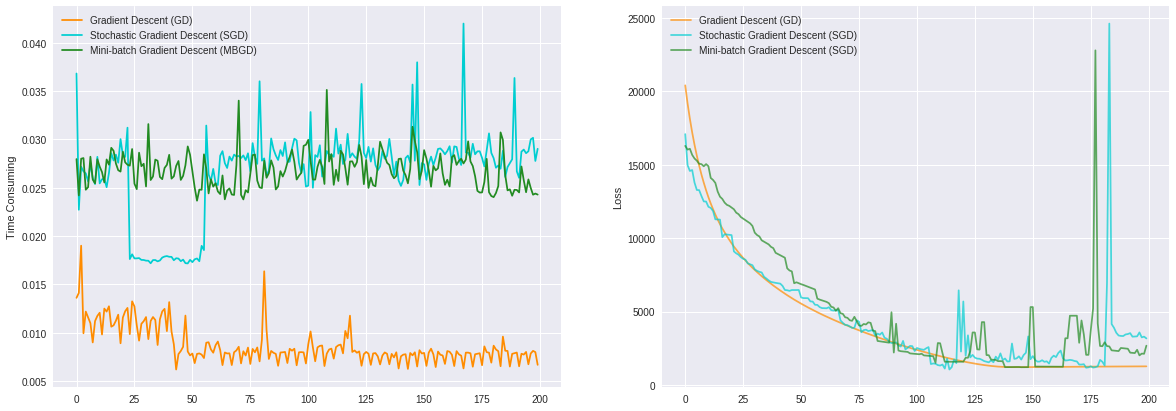

In [0]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,7))

ax[0].plot((range(len(time_list_gd))), time_list_gd,
        color='darkorange', label='Gradient Descent (GD)', alpha=1)
ax[0].plot((range(len(time_list_sgd))), time_list_sgd,
        color='darkturquoise', label='Stochastic Gradient Descent (SGD)', alpha=1)
ax[0].plot((range(len(time_list_mbgd))), time_list_mbgd,
        color='forestgreen', label='Mini-batch Gradient Descent (MBGD)', alpha=1)
ax[0].set_ylabel('Time Consuming')
ax[0].legend(loc='best')

ax[1].scatter(loss_list_gd[1:], color='darkorange', label='Gradient Descent (GD)', alpha=0.7)
ax[1].scatter(loss_list_sgd[1:], color='darkturquoise', label='Stochastic Gradient Descent (SGD)', alpha=0.7)
ax[1].scatter(loss_list_mbgd[1:], color='forestgreen', label='Mini-batch Gradient Descent (SGD)', alpha=0.7)
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

In [0]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,7))

weights_lg = np.array([0.01756025, 0.03692777, 1.9450373543725836])
ani = visualize_loss_and_scatterplot(fig, ax, X, y, weights_gd, weights_sgd, weights_mbgd, weights_lg)

plt.close()
rc('animation', html='jshtml')
ani

Output hidden; open in https://colab.research.google.com to view.